# 26 - Strength and opportunities analysis

Strength and opportunities analysis by area of analysis

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
from scipy.stats import f_oneway
import scipy.stats as stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pingouin as pg

import numpy as np
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Config notebook

## Config notebook

In [2]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to database?
save = False
# How to save?
if_exists='append'
# save to local?
save_local = False
# use local data?
local_data = False
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

In [3]:
# 'alex' or 'edgar'
all_local_dirs = 'edgar'
# Output hexs resolution
res = 10
# Persona speed
walk_speed = 4.5
speed_name = str(walk_speed).replace('.','_')

In [4]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/external/temporal_todocker/santiago/proximidad/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/santiago/"
else:
    print("WARNING: Fix all_local_dirs variable")

## __Load data__

### __Load data__ - Pois proximity (regular and unique ID pois)

In [5]:
if local_data:
    hex_gdf = gpd.read_file(grl_dir + f'santiago_hexanalysis_{speed_name}_kmh_res{res}.gpkg')
else:
    query = f'SELECT * FROM projects_research.santiago_hexanalysis_{speed_name}_kmh WHERE res = {res}'
    hex_gdf = aup.gdf_from_query(query)

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

(58695, 31)


,wellbeing_supplying,wellbeing_caring,wellbeing_living,wellbeing_enjoying,wellbeing_learning,wellbeing_working,wellbeing,sociability_supplying,sociability_caring,sociability_living,...,hex_id,geometry,supplying,caring,living,enjoying,learning,working,hqsl,res
0,5.833333,5.833333,5.0,5.638199,7.5,4.166667,33.971533,4.583333,1.875,0.543189,...,8ab2c5540647fff,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",5.87963,5.25712,3.59773,4.894993,5.833333,4.943534,30.406339,10


### __Load data__ - Comunas

In [6]:
# From notebook 12-Areal-data-to-hex.ipynb
if all_local_dirs == 'alex':
    comuna_gdf = gpd.read_file(grl_dir + 'santiago_comunas.geojson')
elif all_local_dirs == 'edgar':
    comuna_gdf = gpd.read_file(grl_dir + 'santiago_comunas.geojson')

# Show
comuna_gdf = comuna_gdf.explode()
comuna_gdf['area_ha'] = comuna_gdf.to_crs("EPSG:32719").area/10000
comuna_gdf = comuna_gdf[['Comuna','area_ha','geometry']]
comuna_gdf = comuna_gdf.rename(columns={'Comuna':'Nombre'})
comuna_gdf = comuna_gdf.reset_index(drop=True)
print(comuna_gdf.shape)
comuna_gdf.head(1)

(36, 3)


,Nombre,area_ha,geometry
0,San Joaquín,987.687671,"POLYGON ((-70.62342 -33.47338, -70.62292 -33.4..."


### __Load data__ - Buffer Alameda

In [7]:
# From notebook 12-Areal-data-to-hex.ipynb
if all_local_dirs == 'alex':
    alameda_gdf = gpd.read_file(grl_dir + 'unidades_vecinales_buffer800m_alameda_v2.gpkg')
elif all_local_dirs == 'edgar':
    alameda_gdf = gpd.read_file(grl_dir + 'unidades_vecinales_buffer800m_alameda_v2.gpkg')

# Show
alameda_gdf = alameda_gdf.dissolve()
alameda_gdf['area_ha'] = alameda_gdf.to_crs("EPSG:32719").area/10000
alameda_gdf['Nombre'] = 'Nueva Alameda'
alameda_gdf = alameda_gdf[['Nombre','area_ha','geometry']]
print(alameda_gdf.shape)
alameda_gdf.head(1)

(1, 3)


,Nombre,area_ha,geometry
0,Nueva Alameda,2266.840098,"POLYGON ((-70.71634 -33.46959, -70.71651 -33.4..."


### Load data -- Alameda by zone

In [8]:
# ALAMEDA PONIENTE
alameda_poniente = gpd.read_file(grl_dir + 'alameda_poniente.gpkg')
alameda_poniente['Nombre'] = 'alameda_poniente'
alameda_poniente = alameda_poniente[['Nombre','geometry']]
alameda_poniente = alameda_poniente.to_crs("EPSG:4326")

# ALAMEDA ORIENTE
alameda_oriente = gpd.read_file(grl_dir + 'alameda_oriente.gpkg')
alameda_oriente['Nombre'] = 'alameda_oriente'
alameda_oriente = alameda_oriente[['Nombre','geometry']]
alameda_oriente = alameda_oriente.to_crs("EPSG:4326")

### Load data -- Unidades vecinales

In [9]:
# UNIDADES VECINALES
unidades_vecinales = gpd.read_file(grl_dir + 'alameda_unidadesvecinales_clusteranalysis_v3.geojson')
unidades_vecinales['Nombre'] = unidades_vecinales['COD_UNICO_']
unidades_vecinales = unidades_vecinales[['Nombre','geometry']]
unidades_vecinales = unidades_vecinales.to_crs("EPSG:4326")

### Load proximity data

In [10]:
if local_data:
    hex_gdf = gpd.read_file(grl_dir + f'santiago_hexproximity_res{res}_{speed_name}_kmh.geojson')
else:
    table = f'santiago_hexvariableanalysis_{speed_name}_kmh'
    schema = 'projects_research'
    query = f'SELECT * FROM {schema}.{table} WHERE res = {res}'
    hex_prox = aup.gdf_from_query(query)

# Show
print(hex_prox.shape)
hex_prox.head(1)

(44700, 172)


,hex_id,oficinas_count,hotel_count,houses_count,social_viv_count,compact_count,temp_count,inter_count,noise_count,ndvi_count,...,edu_especial_pub_scaled,bibliotecas_scaled,centro_edu_amb_scaled,paradas_tp_ruta_scaled,paradas_tp_metro_scaled,paradas_tp_tren_scaled,oficinas_scaled,ciclovias_scaled,estaciones_bicicletas_scaled,res
0,8ab2c5540647fff,1.186889,0.190803,51.747597,0.0,0.0,0.074183,66.0,58.392857,0.135445,...,3.75,10.0,0.0,10.0,2.5,0.0,0.494537,10.0,6.666667,10


## Parameters dictionary

In [11]:
# --- REQUIRED DATA: parameters dictionary [AS OF 2024 06 28]
# Structure: {social_functions:{themes:[source_names]}}
parameters_dict = {'supplying':{'wellbeing':['carniceria', #Accessibility to Butcher/Fish Shops
                                             'hogar', #Accessibility to Hardware/Paint Shops
                                             #Not available: Accessibility to Greengrocers
                                             'bakeries', #Accessibility to Bakeries and delis
                                             'supermercado',#Accessibility to supermarkets
                                             'banco'#Accessibility to bank
                                            ],
                                'sociability':['ferias',#Accessibility to city fairs/markets
                                               'local_mini_market',#Accessibility to local and mini markets
                                               'correos'#ADDED: MAIL SERVICE
                                              ],
                                'environmental_impact':['centro_recyc'#Accessibility to recycling center
                                                        #Not available: Accessibility to compost
                                                       ]
                               },
                   'caring':{'wellbeing':['hospital', #Accessibility to hospital
                                          'clinica',#Accessibility to public clinics
                                          'farmacia',#Accessibility to pharmacies
                                          'vacunatorio',#Accessibility to vaccination center
                                          'consult_ado',#Accessibility to optician/audiologist(###ADDED DENTIST)
                                          'salud_mental',###ADDED: MENTAL HEALTH
                                          'labs_priv',###ADDED: LABORATORIES
                                          'residencia_adumayor'###ADDED: ELDERLY PERMANENT RESIDENCIES
                                         ],
                             'sociability':['eq_deportivo',#Accessibility to sports equipments
                                            'club_deportivo'#Accessibility to sport clubs
                                           ],
                             'environmental_impact':['noise',
                                                     'temp'
                                 #Not available: Air polution
                                                    ]
                            },
                   'living':{'wellbeing':['civic_office',#Accessibility to civic offices
                                          #Not available: Number of street bentches
                                          'tax_collection',#ADDED: AFIP(TAX COLLECTOR)
                                          'social_security',#ADDED: SOCIAL SECURITY
                                          'police',#Accessibility to police(###MOVED FROM LIVING TO CARING)
                                          'bomberos'#Accessibility to fire stations
                                          #Not available: Accessibility to street lamp
                                         ],
                             'sociability':['houses',#Accessibility to permanent residencies
                                            'social_viv',#Accessibility to social housing
                                            #Not available: Accessibility to student housing
                                            'hotel'#ADDED: HOTELS
                                           ],
                             'environmental_impact':['inter',
                                                     #Not available: Corrected compactness
                                                     #Not available: Width of sidewalks
                                                    ],
                            },
                   'enjoying':{'wellbeing':['museos',#Accessibility to museums
                                            #Not available: Accessibility to theater,operas
                                            'cines',#Accessibility to cinemas
                                            'sitios_historicos',#Accessibility to historical places
                                            'ndvi'#Number of trees
                                           ],
                               'sociability':['restaurantes_bar_cafe',#Accessibility to bars/cafes + Accessibility to restaurants
                                              'librerias',#Accessibility to record and book stores, galleries, fairs
                                              #Not available: Accessibility to cultural and/or formative spaces
                                              #Not available: Accessibility to places of workship
                                              'ep_plaza_small'#Accessibility to boulevards, linear parks, small squares + Accessibility to squares
                                             ],
                               'environmental_impact':['ep_plaza_big'#Accessibility to big parks
                                                       #Not available: Accessibility to shared gardens
                                                       #Not available: Accessibility to urban playgrounds
                                                      ]
                              },
                   'learning':{'wellbeing':['edu_basica_pub',#'edu_basica_priv',#Accessibility to public elementary school
                                            'edu_media_pub',#'edu_media_priv',#Accessibility to public high school
                                            'jardin_inf_pub',#'jardin_inf_priv',#Similar to Accessibility to childcare
                                            'universidad',#Accessibility to university
                                            'edu_tecnica',#ADDED: TECHNICAL EDUCATION
                                           ],
                               'sociability':['edu_adultos_pub',#'edu_adultos_priv',#Accessibility to adult formation centers
                                              'edu_especial_pub',#'edu_especial_priv',#Accessibility to specialized educational centers
                                              #Not available: Accesibility to establishments and services for disabled adults
                                              'bibliotecas'#Accessibility to libraries(###MOVED FROM ENJOYING TO LEARNING)
                                             ],
                               'environmental_impact':['centro_edu_amb'#Accessibility to centers for learning environmental activities
                                                       #Not available: Accessibility to gardening schools
                                                      ],
                              },
                   'working':{'wellbeing':['paradas_tp_ruta',#Accessibility to bus stop
                                           'paradas_tp_metro',#Accessibility to metro
                                           'paradas_tp_tren'#Accessibility to train stop
                                          ],
                              'sociability':['oficinas'#Accessibility to office
                                             #Not available: Accessibility to incubators
                                             #Not available: AccSeveral other articles cite 60dB as a safe noise zone. essibility to coworking places
                                          ],
                              
                              'environmental_impact':['ciclovias',
                                                      'estaciones_bicicletas'#Accessibility to bike lanes
                                                      #Not available: Accessibility to shared bike stations
                                                     ]
                             }
                  }

### Data by area of analysis

In [12]:
nombre_comuna = ['Las Condes','Pedro Aguirre Cerda',
                'Quinta Normal','San Miguel',
                'Maipú','Conchalí','El Bosque',
                'Providencia']

comuna_analysis = comuna_gdf.loc[comuna_gdf.Nombre.isin(nombre_comuna)].copy()

aoi_data = [comuna_analysis,alameda_gdf,alameda_poniente,alameda_oriente,unidades_vecinales]
aoi_df = pd.concat(aoi_data,
                    ignore_index = True, axis = 0)
aoi_df

,Nombre,area_ha,geometry
0,San Miguel,963.502832,"POLYGON ((-70.63659 -33.51873, -70.63740 -33.5..."
1,Providencia,1439.652277,"POLYGON ((-70.58484 -33.43126, -70.58445 -33.4..."
2,Conchalí,1098.672380,"POLYGON ((-70.66314 -33.39923, -70.66400 -33.3..."
3,El Bosque,1426.967489,"POLYGON ((-70.66324 -33.58516, -70.66340 -33.5..."
4,Las Condes,9839.607402,"POLYGON ((-70.53235 -33.38217, -70.53235 -33.3..."
5,Maipú,13803.803111,"POLYGON ((-70.76505 -33.45926, -70.76505 -33.4..."
6,Pedro Aguirre Cerda,850.130544,"POLYGON ((-70.67123 -33.51069, -70.67179 -33.5..."
7,Quinta Normal,1186.605299,"POLYGON ((-70.70527 -33.40762, -70.70463 -33.4..."
8,Nueva Alameda,2266.840098,"POLYGON ((-70.71634 -33.46959, -70.71651 -33.4..."
9,alameda_poniente,NaN,"MULTIPOLYGON (((-70.67975 -33.44347, -70.67894..."


### Spatial intersection

In [13]:
hex_analysis = hex_gdf.merge(hex_gdf.sjoin(aoi_df)[['hex_id','Nombre']], on='hex_id',
                             how='right')
print(hex_analysis.shape)
hex_analysis.head(4)

(17551, 32)


,wellbeing_supplying,wellbeing_caring,wellbeing_living,wellbeing_enjoying,wellbeing_learning,wellbeing_working,wellbeing,sociability_supplying,sociability_caring,sociability_living,...,geometry,supplying,caring,living,enjoying,learning,working,hqsl,res,Nombre
0,5.833333,5.833333,5.000000,5.638199,7.500000,4.166667,33.971533,4.583333,1.875000,0.543189,...,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",5.879630,5.257120,3.597730,4.894993,5.833333,4.943534,30.406339,10,Nueva Alameda
1,2.845833,2.532738,2.836364,4.570114,1.393876,3.750000,17.928926,3.202652,3.052083,0.134702,...,"POLYGON ((-70.54047 -33.41159, -70.54110 -33.4...",3.512286,3.050925,2.731769,5.760304,1.046366,2.500000,18.601651,10,Las Condes
2,0.729167,1.497396,0.000000,2.500000,2.173611,3.333333,10.233507,1.250000,4.479167,0.116598,...,"POLYGON ((-70.69534 -33.46458, -70.69597 -33.4...",0.914352,2.983119,0.969422,2.403274,1.890432,1.732263,10.892862,10,Nueva Alameda
3,1.250000,3.080357,4.250000,0.406806,3.952381,4.166667,17.106211,2.678571,5.000000,0.543317,...,"POLYGON ((-70.67531 -33.57591, -70.67594 -33.5...",2.248677,3.723022,3.653328,2.227213,3.141534,2.916667,17.910441,10,El Bosque


## Strength and opportunity analysis

### Define areas of comparison

In [14]:
comparison_dict = {'alameda':['Nueva Alameda','Las Condes','Pedro Aguirre Cerda',
                'Quinta Normal','San Miguel',
                'Maipú','Conchalí','El Bosque',
                'Providencia'],
                  'alameda_interior':['alameda_poniente','alameda_oriente','Nueva Alameda'],
                  'unidades_vecinales':['13123_14','13101_49','13101_18','13101_13','13106_22','13106_12',
              '13106_06','13106_18','13106_17','13101_3']}

### Comparison analysis

#### Define variables

In [120]:
area_of_analysis = 'alameda_interior' # define comparison elements
area_for_comparison = 'Nueva Alameda' # define vs which element will be compared

col_analysis = ['sociability','wellbeing','environmental_impact',
                  'supplying','caring','living',
                  'enjoying','working','learning',
                  'hqsl']

comparison_areas = comparison_dict[area_of_analysis].copy()
comparison_areas.remove(area_for_comparison)

#### Analysis

In [121]:
df_summary = pd.DataFrame()
df_summary.loc[0,'Nombre'] = area_for_comparison

for c in col_analysis:
    higher_list = []
    lower_list = []
    for area in comparison_areas:
        data_1 = np.array(hex_analysis.loc[hex_analysis.Nombre==area_for_comparison, c])
        data_2 = np.array(hex_analysis.loc[hex_analysis.Nombre==area, c])
        # significance test
        p_val = stats.kruskal(data_1, data_2)[1]
        if p_val < 0.05 and data_1.mean()>data_2.mean():
            higher_list.append(area)
        elif p_val < 0.05 and data_1.mean()<data_2.mean():
            lower_list.append(area)
    
    df_summary.loc[df_summary.Nombre==area_for_comparison,f'{c}_mean'] = data_1.mean()
    df_summary.loc[df_summary.Nombre==area_for_comparison,f'{c}_higher_than'] = str(higher_list)
    df_summary.loc[df_summary.Nombre==area_for_comparison,f'{c}_lower_than'] = str(lower_list)

In [122]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

df_summary.T.style

,0
Nombre,Nueva Alameda
sociability_mean,20.903044
sociability_higher_than,"['Las Condes', 'Pedro Aguirre Cerda', 'Quinta Normal', 'San Miguel', 'Maipú', 'Conchalí', 'El Bosque', 'Providencia']"
sociability_lower_than,[]
wellbeing_mean,28.586152
wellbeing_higher_than,"['Las Condes', 'Pedro Aguirre Cerda', 'Quinta Normal', 'San Miguel', 'Maipú', 'Conchalí', 'El Bosque', 'Providencia']"
wellbeing_lower_than,[]
environmental_impact_mean,31.405509
environmental_impact_higher_than,"['Las Condes', 'Pedro Aguirre Cerda', 'Quinta Normal', 'San Miguel', 'Maipú', 'Conchalí', 'El Bosque']"
environmental_impact_lower_than,['Providencia']


#### Comparison by social function

In [125]:
social_function_cols = ['supplying','caring','living',
                  'enjoying','working','learning']

In [126]:
df_summary = pd.DataFrame()
df_summary.loc[0,'Nombre'] = area_for_comparison

analyzed_cols = []

for c in social_function_cols:
    higher_list = []
    lower_list = []
    analyzed_cols.append(c)
    for comparison_col in social_function_cols:
        # if comparison_col in analyzed_cols:
        #    continue
        if comparison_col == c:
            continue
        data_1 = np.array(hex_analysis.loc[hex_analysis.Nombre==area_for_comparison, c])
        data_2 = np.array(hex_analysis.loc[hex_analysis.Nombre==area_for_comparison, comparison_col])
        # significance test
        p_val = stats.kruskal(data_1, data_2)[1]
        if p_val < 0.05 and data_1.mean()>data_2.mean():
            higher_list.append(comparison_col)
        elif p_val < 0.05 and data_1.mean()<data_2.mean():
            lower_list.append(comparison_col)
    
    df_summary.loc[df_summary.Nombre==area_for_comparison,f'{c}_mean'] = data_1.mean()
    df_summary.loc[df_summary.Nombre==area_for_comparison,f'{c}_higher_than'] = str(higher_list)
    df_summary.loc[df_summary.Nombre==area_for_comparison,f'{c}_lower_than'] = str(lower_list)

In [127]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

df_summary.T.style

,0
Nombre,Nueva Alameda
supplying_mean,5.232719
supplying_higher_than,"['caring', 'living', 'working', 'learning']"
supplying_lower_than,[]
caring_mean,4.293567
caring_higher_than,"['living', 'learning']"
caring_lower_than,"['supplying', 'enjoying', 'working']"
living_mean,3.769314
living_higher_than,[]
living_lower_than,"['supplying', 'caring', 'enjoying', 'working']"


#### Comparison by indicator

In [128]:
indicators_cols = ['sociability','wellbeing','environmental_impact',]

In [129]:
df_summary = pd.DataFrame()
df_summary.loc[0,'Nombre'] = area_for_comparison

analyzed_cols = []

for c in indicators_cols:
    higher_list = []
    lower_list = []
   # analyzed_cols.append(c)
    for comparison_col in indicators_cols:
        # if comparison_col in analyzed_cols:
        #    continue
        if comparison_col == c:
            continue
        data_1 = np.array(hex_analysis.loc[hex_analysis.Nombre==area_for_comparison, c])
        data_2 = np.array(hex_analysis.loc[hex_analysis.Nombre==area, comparison_col])
        # significance test
        p_val = stats.kruskal(data_1, data_2)[1]
        if p_val < 0.05 and data_1.mean()>data_2.mean():
            higher_list.append(comparison_col)
        elif p_val < 0.05 and data_1.mean()<data_2.mean():
            lower_list.append(comparison_col)
    
    df_summary.loc[df_summary.Nombre==area_for_comparison,f'{c}_mean'] = data_1.mean()
    df_summary.loc[df_summary.Nombre==area_for_comparison,f'{c}_higher_than'] = str(higher_list)
    df_summary.loc[df_summary.Nombre==area_for_comparison,f'{c}_lower_than'] = str(lower_list)

In [130]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

df_summary.T.style

,0
Nombre,Nueva Alameda
sociability_mean,20.903044
sociability_higher_than,[]
sociability_lower_than,"['wellbeing', 'environmental_impact']"
wellbeing_mean,28.586152
wellbeing_higher_than,['sociability']
wellbeing_lower_than,['environmental_impact']
environmental_impact_mean,31.405509
environmental_impact_higher_than,"['sociability', 'wellbeing']"
environmental_impact_lower_than,[]


### Variance analysis

#### Variance indicator analysis

In [131]:
indicators_cols = ['sociability','wellbeing','environmental_impact',]

In [132]:
df_summary

,Nombre,sociability_mean,sociability_higher_than,sociability_lower_than,wellbeing_mean,wellbeing_higher_than,wellbeing_lower_than,environmental_impact_mean,environmental_impact_higher_than,environmental_impact_lower_than
0,Nueva Alameda,20.903044,[],"['wellbeing', 'environmental_impact']",28.586152,['sociability'],['environmental_impact'],31.405509,"['sociability', 'wellbeing']",[]


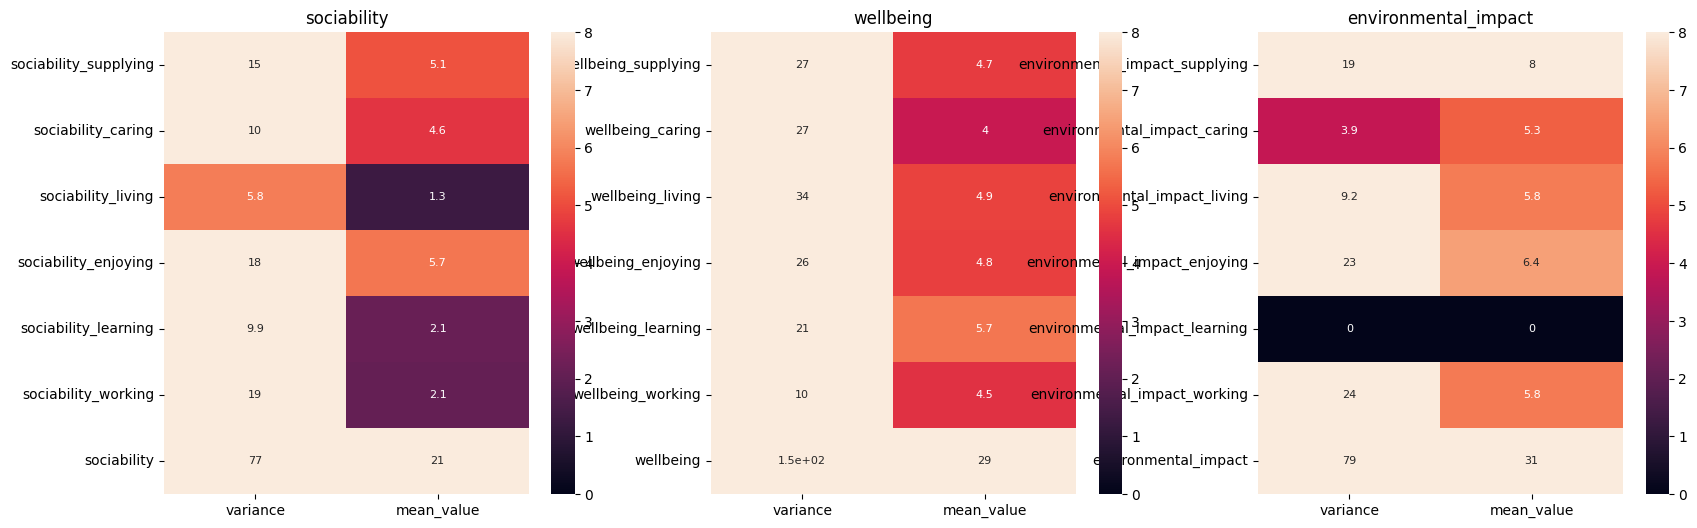

In [133]:
df_summary = pd.DataFrame(columns=['supplying','caring','living',
                  'enjoying','working','learning','indicator'])

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
i = 0
col_list = list(cov_df.columns)

r = 0
c = -1
checker = 0

for covariance_variable in indicators_cols:

    if c < 2:
        c +=1
        
    cov_df = hex_analysis.loc[hex_analysis.Nombre==area_for_comparison].drop(columns=['Nombre','hex_id','res','geometry'])
    cov_cols = [c for c in cov_df.columns if covariance_variable in c]
    cov_df = cov_df[cov_cols]
    
    df_summary = cov_df.cov()[[covariance_variable]]
    df_summary = df_summary.merge(pd.DataFrame(cov_df.mean()), left_index=True, right_index=True)
    df_summary = df_summary.rename(columns={covariance_variable:'variance',
                                            0:f'mean_value'})
    
    sns.heatmap(df_summary, vmin=0, vmax=8, annot=True, annot_kws={"fontsize":8}, ax=ax[c])
    ax[c].set_title(covariance_variable)

plt.show()

### Sociability covariance

In [134]:
social_fn_cols = ['supplying','caring','living',
                  'enjoying','working','learning']

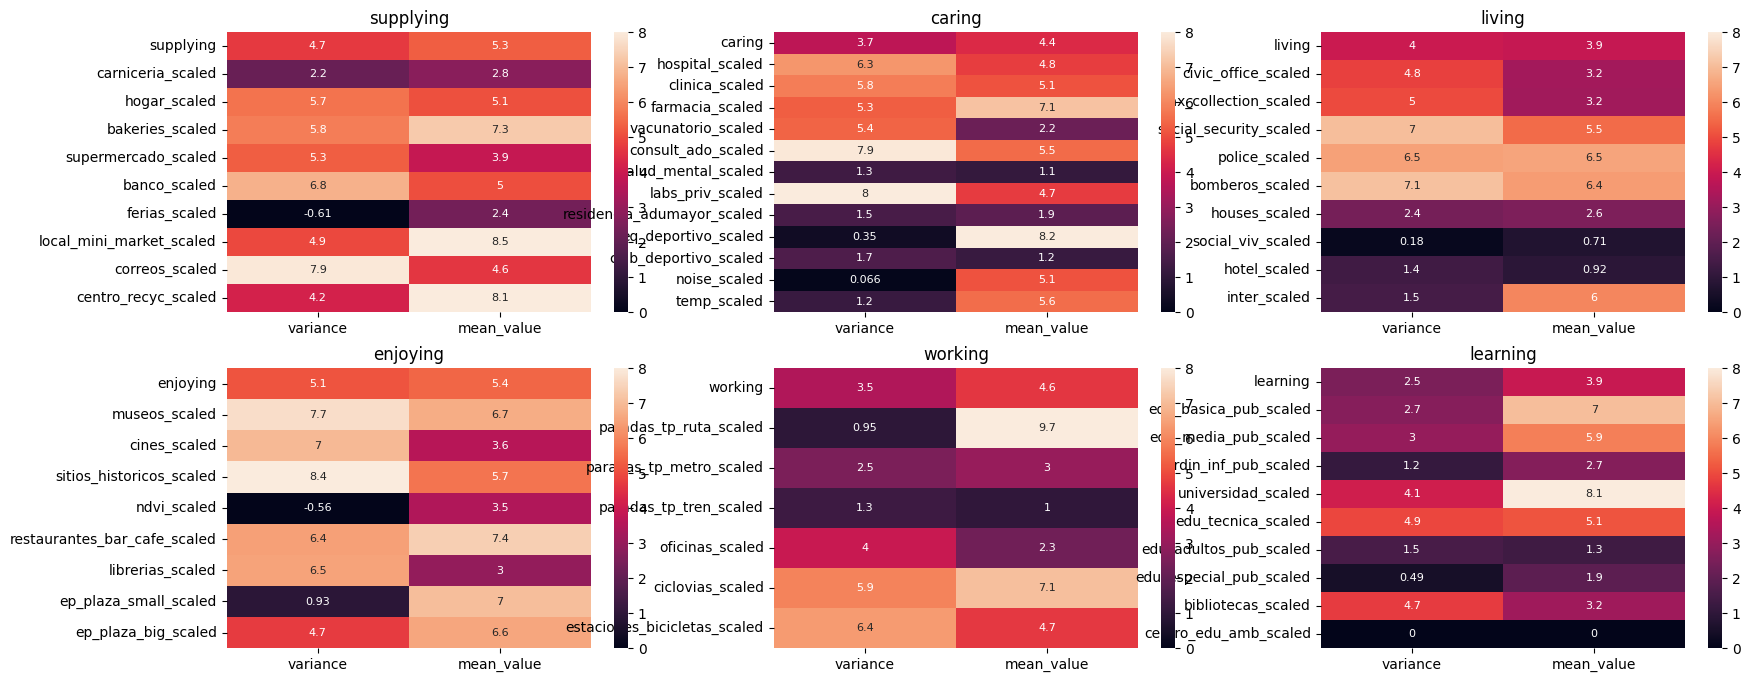

In [135]:
df_summary = pd.DataFrame(columns=['supplying','caring','living',
                  'enjoying','working','learning'])

fig, ax = plt.subplots(2, 3, figsize=(20, 8))
i = 0
col_list = list(cov_df.columns)

r = 0
c = -1
checker = 0

for covariance_variable in social_fn_cols:
    if r < 1 and c==2:
        r +=1
    if c < 2:
        c +=1
    if r == 1 and checker == 0:
        c = 0
        checker += 1

    metric_list = []

    # Convert social function 'sf_count_15min' name to 'sf_scaledcount' name
    for val in parameters_dict[covariance_variable].values():
        for v in val:
            metric_list.append(v+'_scaled')
    
    metric_list.append('hex_id')
    cov_df = hex_analysis.loc[hex_analysis.Nombre==area_for_comparison, ['hex_id',covariance_variable]]
    cov_df = cov_df.merge(hex_prox[metric_list], on='hex_id')
    
    cov_df = cov_df.drop(columns=['hex_id'])
    
    df_summary = cov_df.cov()[[covariance_variable]]
    df_summary = df_summary.merge(pd.DataFrame(cov_df.mean()), left_index=True, right_index=True)
    df_summary = df_summary.rename(columns={covariance_variable:'variance',
                                            0:f'mean_value'})
    
    sns.heatmap(df_summary, vmin=0, vmax=8, annot=True, annot_kws={"fontsize":8}, ax=ax[r][c])
    ax[r][c].set_title(covariance_variable)

plt.show()

In [90]:
hqsl_array = [np.array(hex_anova.loc[hex_anova.Nombre==n,variable_analysis]) for n in hex_anova.Nombre.unique()]
data_1 = hqsl_array[0]
data_2 = hqsl_array[1]
data_3 = hqsl_array[2]
data_4 = hqsl_array[3]
data_5 = hqsl_array[4]

NameError: name 'hex_anova' is not defined

NameError: name 'data_1' is not defined